In [1]:
require('rstan')
require('tidyverse')
require('data.table')
source("../src/04_bmm/model_utils.R")
source("../src/04_bmm/snp_utils.R")
source("../src/04_bmm/heritability_utils.R")
options(stringsAsFactors=FALSE)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The followi

### ANTHRO TRAITS
where is the anthro data? what does it look like?

In [9]:
anthro_traits <- c("afr", "tfr", "lfr", "whr")

In [3]:
getTraitDf <- function(trait){
    load(sprintf("../data/vary_priors_%s/m2_fit_2.RData", trait))
    summary_df <- data.frame(summary(fit, pars=c("pi", "sigmasq"))$summary)
    summary_df$parameter <- rownames(summary_df)
    summary_df$trait <- trait
    summary_df_long <- summary_df %>% 
        dplyr::select(trait, parameter, "X2.5.", "X50.", "X97.5.", "n_eff", "Rhat") %>%
        rename(ci_l="X2.5.", est="X50.", ci_u="X97.5.") %>%
        as_tibble()
    return(summary_df_long)
}

trait_est <- do.call(rbind, lapply(antrho_traits, getTraitDf))


In [44]:
reformDf <- function(df){
    df %>%
    dplyr::select(trait, parameter, est) %>% 
    tidyr::pivot_wider(id_cols=trait, names_from="parameter", values_from="est") %>%
    rename("pi[0]"="pi[1]",
          "pi[1]"="pi[2]",
          "pi[2]"="pi[3]",
          "pi[3]"="pi[4]",
          "sigmasq[1f]"="sigmasq[1]",
           "sigmasq[2m]"="sigmasq[2]",
           "sigmasq[3f]"="sigmasq[3]",
           "sigmasq[3m]"="sigmasq[4]"
          ) %>%
    mutate_if(is.numeric, ~signif(., digits=4))
}

In [75]:
summary(trait_est$n_eff)
summary(trait_est$Rhat)
trait_reform <- reformDf(trait_est)
trait_reform %>% 
    mutate(trait=case_when(
        trait=="afr" ~ "arm fat ratio",
        trait=="tfr" ~ "trunk fat ratio" ,
        trait=="lfr" ~ "leg fat ratio",
        TRUE ~ trait)) %>%
    write_csv("../data/outfiles/m2_anthro_est.csv")

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1939    2608    2968    3154    3665    4795 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9994  0.9999  1.0004  1.0005  1.0009  1.0020 

### BIOMARKER TRAITS
Which converged?

In [23]:
bio_traits_f <- str_replace_all(list.files(path="../data2/m2/", pattern="f*.RData"), "f_m2_|.RData", "")
bio_traits_p <- str_replace_all(list.files(path="../data/m2/", pattern="f*.RData"), "f_m2_|.RData", "")

In [26]:
bio_traits_f # 19

bio_missing_full <-setdiff(bio_traits_p, c(bio_traits_f, anthro_traits))
bio_missing_full # 14


[1] "Alanine_aminotransferase"   "Albumin"                   
 [3] "Alkaline_phosphatase"       "Apolipoprotein_A"          
 [5] "Aspartate_aminotransferase" "C_reactive_protein"        
 [7] "Cystatin_C"                 "Gamma_glutamyltransferase" 
 [9] "HDL_cholesterol"            "IGF_1"                     
[11] "LDL_direct"                 "Non_albumin_protein"       
[13] "SHBG"                       "Sodium_in_urine"           
[15] "Testosterone"               "Total_bilirubin"           
[17] "Urate"                      "Urea"                      
[19] "Vitamin_D"

[1] "Apolipoprotein_B"           "Calcium"                   
 [3] "Cholesterol"                "Creatinine_in_urine"       
 [5] "Creatinine"                 "Direct_bilirubin"          
 [7] "eGFR"                       "Glucose"                   
 [9] "Glycated_haemoglobin_HbA1c" "Lipoprotein_A"             
[11] "Phosphate"                  "Potassium_in_urine"        
[13] "Total_protein"              "Triglycerides"

In [32]:
getTraitDfBio <- function(trait, my.dir="data2"){
    load(sprintf("../%s/m2/f_m2_%s.RData",  my.dir, trait))
    summary_df <- data.frame(summary(fit2, pars=c("pi", "sigmasq"))$summary)
    summary_df$parameter <- rownames(summary_df)
    summary_df$trait <- trait
    summary_df_long <- summary_df %>% 
        dplyr::select(trait, parameter, "X2.5.", "X50.", "X97.5.", "n_eff", "Rhat") %>%
        rename(ci_l="X2.5.", est="X50.", ci_u="X97.5.") %>%
        as_tibble()
    return(summary_df_long)
}

trait_est_bio_f <- do.call(rbind, lapply(bio_traits_f, getTraitDfBio))


In [33]:
trait_est_bio_p <- do.call(rbind, lapply(bio_traits_p, getTraitDfBio, my.dir="data"))


In [35]:
# check convergence
summary(trait_est_bio_f$n_eff)
summary(trait_est_bio_f$Rhat)
summary(trait_est_bio_p$n_eff)
summary(trait_est_bio_p$Rhat)

# these all look fine

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1644    3864    4490    4471    5037    6775 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9991  0.9996  0.9999  1.0001  1.0005  1.0018 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  767.6  1359.8  1647.4  1670.0  1955.4  2913.1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9977  0.9990  0.9997  1.0000  1.0006  1.0068 

`geom_smooth()` using formula 'y ~ x'



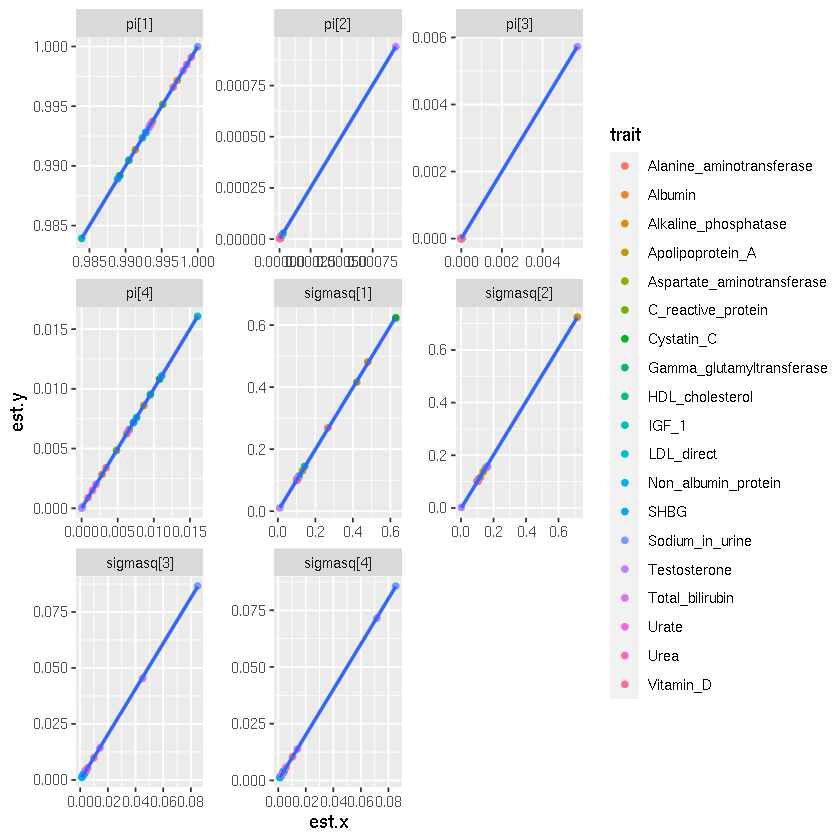

In [63]:
compare_df <- trait_est_bio_f %>% inner_join(trait_est_bio_p, by=c("trait", "parameter"))
ggplot(compare_df, aes(x=est.x, y=est.y))+geom_point(aes(col=trait))+
geom_smooth(method="lm")+
facet_wrap(~parameter, scales="free")

# seems like things line up exactly??? need to zoom in tho

`geom_smooth()` using formula 'y ~ x'



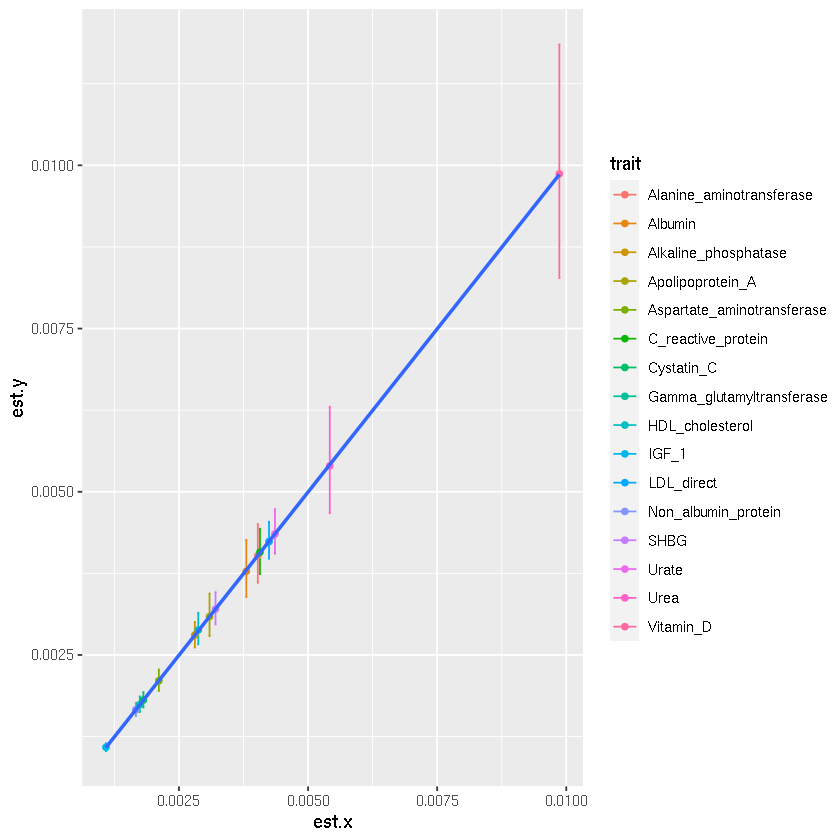

In [67]:
ggplot(compare_df %>% filter(parameter=="sigmasq[3]" & est.y < 0.01), aes(x=est.x, y=est.y))+
geom_errorbar(aes(ymin=ci_l.y, ymax=ci_u.y, col=trait))+
geom_point(aes(col=trait))+
geom_smooth(method="lm")
# still looks good!!

In [72]:
# clean up, combine, and write out
bio_f <- trait_est_bio_f %>% reformDf()
bio_p <-trait_est_bio_p %>% reformDf()

bio_p %>% 
    anti_join(bio_f, by="trait") %>% 
    filter(!trait %in% anthro_traits) %>%
    bind_rows(bio_f) %>% 
    mutate(trait=str_replace_all(trait, "_", " ")) %>%
    arrange(trait) %>%
    write_csv("../data/outfiles/m2_biomarker_est.csv")

### Creating an annotation table
- grab the variants
- what is the info we want

trait	ID	CHR	POS	REF	ALT	GENE	MAF	B.f	B.m	SE.f	SE.m	P.f	P.m	p0	p1	p2	p3	Consequence	HGVSp

In [21]:
loadM2Tab <- function(trait, M2.DIR="data2"){
    df <- read.table(sprintf("../%s/m2/sig_snps%s_.txt", M2.DIR, trait), sep=" ", header=TRUE); 
    df %>% 
        rename(ID=SNP, p0=p1, p1=p2, p2=p3, p3=p4) %>%
        mutate(category=category-1) %>%
        mutate(trait=trait)
}


In [27]:
m2_tab_bio_f <- do.call(rbind, lapply(bio_traits_f, loadM2Tab))


In [32]:
m2_tab_bio_p <- do.call(rbind, lapply(bio_missing_full, function(x) loadM2Tab(x, M2.DIR="data")))

In [34]:
m2_bio <- rbind(m2_tab_bio_f, m2_tab_bio_p)

In [2]:
variant_tab <- fread('/oak/stanford/groups/mrivas/private_data/ukbb/variant_filtering/variant_filter_table.new.tsv.gz', data.table=FALSE)

In [3]:
variant_sm <- variant_tab %>% dplyr::select( ID, POS, REF, ALT, Gene_symbol, maf, Consequence, HGVSp) 
head(variant_sm)

,ID,POS,REF,ALT,Gene_symbol,maf,Consequence,HGVSp
,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,rs28659788,723307,C,G,AL669831.5,0.03614952,intron_variant,
2,rs116587930,727841,G,A,AL669831.5,0.05360614,intron_variant,
3,rs116720794,729632,C,T,AL669831.5,0.03658726,intron_variant,
4,rs3131972,752721,A,G,RP11-206L10.10,0.15681154,intron_variant,
5,rs12184325,754105,C,T,FAM87B,0.03652657,splice_region_variant,
6,rs3131962,756604,A,G,RP11-206L10.10,0.12983398,upstream_gene_variant,


In [4]:
# add in the X chromosome info we can get + make a list of X chromosome IDs we'll have to run through VEP 
# (make sure the MAF is correct)

zs <- fread("../data/gwas/ukb24983_v2_hg19.Testosterone_zerosex.genotyped.glm.linear", data.table=FALSE)
Xqc <- fread("../data/chr_qc/chrX_qc_table.txt", data.table=FALSE)
XYqc <- fread("../data/chr_qc/chrXY_qc_table.txt", data.table=FALSE)

In [5]:
XXY <- rbind(Xqc, XYqc)
XY_g <- zs %>% rename("CHR"="#CHROM") %>% filter(CHR %in% c("X", "XY"))

In [6]:
xDat <- left_join(XY_g, XXY %>% dplyr::select(SNP, A1, A2, MAF), by=c("ID"="SNP"))

In [7]:
#summary(xDat$MAF)
xDat2 <- xDat %>% mutate(MAF=1-MAF) %>% dplyr::select(ID, CHR, POS, REF, ALT, MAF) # fix this. 
#xDat2 %>% group_by(CHR) %>% summarize(median=median(MAF), max=max(MAF))
head(xDat2)

,ID,CHR,POS,REF,ALT,MAF
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
1,rs34557243,XY,60425,C,A,0.038610
2,rs28494123,XY,60454,A,G,0.518758
3,rs28590175,XY,61067,A,G,0.046891
4,rs117654552,XY,62079,C,G,0.039522
5,rs28491545,XY,62615,A,C,0.521167
6,rs73174453,XY,167755,G,T,0.537982


In [8]:
variant_sm2 <- variant_sm %>% rename(MAF=maf, GENE=Gene_symbol) 


variant_tab <- xDat2 %>% mutate(GENE="", Consequence="", HGVSp="") %>% dplyr::select(colnames(variant_sm2)) %>%
bind_rows(variant_sm2)



In [42]:
m2_bio_a <- m2_bio %>% left_join(variant_tab, by=c("ID")) %>%
dplyr::select(trait, ID, CHR, POS,REF,ALT,GENE,MAF,B.f,B.m,SE.f,SE.m,P.f,P.m,p0,p1,p2,p3,category,Consequence,HGVSp)

In [43]:
m2_bio_a2 <- m2_bio_a %>% 
    mutate(POS=as.character(POS)) %>% 
    mutate_if(is.numeric, ~signif(., digits=4)) %>%
    mutate(trait=str_replace_all(trait, "_", " ")) %>%
    arrange(trait, CHR, POS)

In [46]:
table(m2_bio_a2[,c("trait", "category")])

                            category
trait                           1    2    3
  Alanine aminotransferase      2    0  696
  Albumin                       0    0  565
  Alkaline phosphatase          5    5 1727
  Apolipoprotein A              5    2 1216
  Apolipoprotein B              0    0 1526
  Aspartate aminotransferase    3    0 1184
  C reactive protein            1    0 1005
  Calcium                       0    0  487
  Cholesterol                   1    0 1869
  Creatinine                    2    1 2077
  Creatinine in urine           0    0    1
  Cystatin C                    1    1 1842
  Direct bilirubin              0    0  317
  eGFR                          2    1 1777
  Gamma glutamyltransferase     0    0 1618
  Glucose                       0    0  167
  Glycated haemoglobin HbA1c    3    3 1960
  HDL cholesterol               8    2 1458
  IGF 1                         1    0 2370
  LDL direct                    1    0 1566
  Lipoprotein A                 0    0 

In [45]:
m2_bio_a2 %>% write_csv("../data/outfiles/m2_bio_snps.csv")

### get tables for the anthro traits

In [47]:
extractDataM2 <- function(trait){
    print("Extracting")
    print(trait)

    load(file=sprintf("../data/vary_priors_%s/dat_%s.RData", trait, trait)) 
    load(file=sprintf("../data/vary_priors_%s/m2_fit_2.RData", trait))

    # fraction in non-null component
    p <- getPi(fit)

    # sigmasq
    sigmasq <- getVars(fit)
    Sigma <- getSigma(fit)
 
    # assign each SNP to a category
    posterior.df <- posteriorSNPtable(dat, fit)
    write.table(posterior.df, file=sprintf("../data/vary_priors_%s/snp_table_%s.txt", trait, trait), row.names=FALSE, quote=FALSE)
    print("Posterior table generated")

    # remove large files from the workspace
    rm(fit)

    cat.count <- table(posterior.df$category)
    print(cat.count)

    # create a data frame with the pvalues
    p.df <- dat$p 
    se.df <- dat$dat$SE
    beta.df <- dat$dat$B
    snp.df <- data.frame(dat$snp)
    chr.df <- data.frame(dat$chr)
    full.df <- do.call(cbind, list(snp.df, chr.df, beta.df, se.df, p.df))
    colnames(full.df) <- c("SNP", "CHR", "B.f", "B.m", "SE.f", "SE.m", "P.f", "P.m")
    comb.df <- cbind(full.df, posterior.df %>% dplyr::select(p1, p2, p3, p4, category))
    non.null.snps <- comb.df %>% dplyr::filter(category %in% c(2,3,4))
    write.table(non.null.snps, file=sprintf("../data/vary_priors_%s/sig_snps%s_.txt", trait,trait), row.names=FALSE)
     
   
}

In [48]:
extractDataM2("afr")

[1] "Extracting"
[1] "afr"
[1] "Posterior table generated"

     1      2      3      4 
336143   1213     26      6 


In [49]:
extractDataM2("tfr")
extractDataM2("lfr")
extractDataM2("whr")

[1] "Extracting"
[1] "tfr"
[1] "Posterior table generated"

     1      2      4 
334831   2323     58 
[1] "Extracting"
[1] "lfr"
[1] "Posterior table generated"

     1      2      4 
335247   1692     48 
[1] "Extracting"
[1] "whr"
[1] "Posterior table generated"

     1      2      4 
336232    749    181 


In [ ]:
### grab the anthro tables

In [10]:
loadM2TabAnthro <- function(trait){
    df <- read.table(sprintf("../data/vary_priors_%s/sig_snps%s_.txt", trait, trait), sep=" ", header=TRUE); 
    df %>% 
        rename(ID=SNP, p0=p1, p1=p2, p2=p3, p3=p4) %>%
        mutate(category=category-1) %>%
        mutate(trait=trait)
}


,ID,CHR,B.f,B.m,SE.f,SE.m,P.f,P.m,p0,p1,p2,p3,category,trait
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,rs28371904,XY,-0.0134932,-0.00596736,1.314548e-05,1.379506e-05,1.98053e-04,0.108134,0.335816673,0.6641734,3.132395e-06,6.840757e-06,1,afr
2,rs35507574,XY,0.0169679,0.00397582,1.239315e-05,1.313707e-05,1.43763e-06,0.272675,0.005047195,0.9949475,2.307227e-08,5.324308e-06,1,afr
3,rs28664665,XY,-0.0124587,-0.00348781,1.230585e-05,1.302394e-05,3.83091e-04,0.333818,0.488465154,0.5115307,1.943388e-06,2.212688e-06,1,afr
4,rs73187767,X,0.0325769,-0.00612428,7.088748e-05,3.710077e-05,1.09218e-04,0.314678,0.168662573,0.8313259,1.176173e-06,1.038357e-05,1,afr
5,rs5990957,X,0.0284206,-0.00123271,4.894639e-05,2.561909e-05,4.86114e-05,0.807584,0.090200175,0.9097944,3.250042e-07,5.134823e-06,1,afr
6,rs3932236,X,0.0326587,0.00344282,7.151425e-05,3.791148e-05,1.12542e-04,0.576060,0.172436175,0.8275556,8.576102e-07,7.390837e-06,1,afr


In [12]:
m2_tab_anthro <- do.call(rbind, lapply(anthro_traits, loadM2TabAnthro))

m2_anthro <- m2_tab_anthro %>% left_join(variant_tab, by=c("ID")) %>%
dplyr::select(trait, ID, CHR, POS,REF,ALT,GENE,MAF,B.f,B.m,SE.f,SE.m,P.f,P.m,p0,p1,p2,p3,category,Consequence,HGVSp)


In [14]:
m2_anthro2 <- m2_anthro %>% 
    mutate(POS=as.character(POS)) %>% 
    mutate_if(is.numeric, ~signif(., digits=4)) %>%
    mutate(trait=case_when(
        trait=="afr" ~ "arm fat ratio",
        trait=="tfr" ~ "trunk fat ratio" ,
        trait=="lfr" ~ "leg fat ratio",
        TRUE ~ trait))  %>%    
    arrange(trait, CHR, POS)

In [15]:
m2_anthro2 %>% write_csv("../data/outfiles/m2_anthro_snps.csv")

### CALCULATE THE FDR

In [16]:
head(m2_anthro2)

,trait,ID,CHR,POS,REF,ALT,GENE,MAF,B.f,B.m,⋯,SE.m,P.f,P.m,p0,p1,p2,p3,category,Consequence,HGVSp
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,arm fat ratio,rs10881467,1,107990347,A,G,NTNG1,0.29680,-0.01934,-0.0053190,⋯,1.424e-05,1.269e-07,0.158700,0.0004921,0.9995,3.464e-09,8.645e-06,1,intron_variant,
2,arm fat ratio,Affx-4028723,1,10838556,C,A,CASZ1,0.05408,0.02901,0.0212500,⋯,5.787e-05,9.163e-05,0.005214,0.1479000,0.8517,3.822e-05,3.525e-04,1,intron_variant,
3,arm fat ratio,rs78852738,1,109800086,A,C,CELSR2,0.02944,-0.03380,-0.0159900,⋯,1.049e-04,6.245e-04,0.118300,0.4799000,0.5201,1.145e-05,2.316e-05,1,intron_variant,
4,arm fat ratio,rs66683180,1,110673169,G,T,,0.05255,-0.02655,-0.0154600,⋯,5.874e-05,4.446e-04,0.043660,0.4110000,0.5889,1.660e-05,3.536e-05,1,regulatory_region_variant,
5,arm fat ratio,rs15396,1,111891170,A,C,PIFO,0.07520,0.02644,0.0002925,⋯,4.215e-05,3.297e-05,0.964100,0.0662700,0.9337,2.976e-07,6.190e-06,1,missense_variant,"ENSP00000358752.4:p.Lys64Asn,ENSP00000358753.4:p.Lys97Asn"
6,arm fat ratio,rs116062834,1,112054063,C,T,TMIGD3,0.01668,-0.04897,0.0104100,⋯,1.773e-04,2.068e-04,0.434300,0.3078000,0.6921,3.832e-06,2.884e-05,1,intron_variant,


In [17]:

#snps <- do.call(rbind, lapply(m2_biomarkers, function(trait) 
#    read_csv(sprintf("../data/res_1024/m2/snp_table_%s.txt", trait)) %>% mutate(trait=trait)))
#cutoff <- 0.8
calcFDRM2 <- function(snps, trait.name, cutoff){

    f_t <- snps %>% filter(trait==trait.name & p1 > cutoff) 
    m_t <- snps %>% filter(trait==trait.name & p2 > cutoff) 
    s_t <- snps %>% filter(trait==trait.name & p3 > cutoff)
    
    f_fdr <- ifelse(length(f_t$p0) > 5, sum(f_t$p0)/(length(f_t$p1)), NA)
    m_fdr <- ifelse(length(m_t$p0) > 5, sum(m_t$p0)/(length(m_t$p2)), NA)
    s_fdr <- ifelse(length(s_t$p0) > 5, sum(s_t$p0)/(length(s_t$p3)), NA)

    return(data.frame(list("trait"=trait.name, "cutoff"=cutoff, "f"=f_fdr, "m"=m_fdr, "s"=s_fdr)))
}

fdr_tabs <- do.call(rbind, lapply(m2_biomarkers, function(trait) 
                   do.call(rbind, lapply(seq(0.5, 0.9, 0.1), 
                                        function(cutoff) calcFDRM2(trait, cutoff)))))
#fdr_tabs %>% write_csv("../data/res_1024/m2_fdr.csv")
#fat_dist <- c("arm_fp", "leg_fp", "whr", "trunk_fp")
#fdr_tabs %>% filter(!trait %in% fat_dist) %>% write_csv("../data/res_1024/m2_fdr_biomarker.csv")
#fdr_tabs %>% filter(trait %in% fat_dist) %>% write_csv("../data/res_1024/m2_fdr_counts.csv")                      

In [22]:
list_traits <- unique(m2_anthro2$trait)

fdr_tabs_anthro <- do.call(rbind, lapply(list_traits, function(trait) 
                   do.call(rbind, lapply(seq(0.5, 0.9, 0.1), 
                                        function(cutoff) calcFDRM2(m2_anthro2, trait, cutoff)))))


In [25]:
fdr_tabs_anthro %>% mutate_if(is.numeric, ~signif(., digits=4)) %>% write_csv("../data/outfiles/anthro_fdr.csv")

In [27]:

fdr_tabs_bio <- do.call(rbind, lapply(unique(m2_bio_a2$trait), function(trait) 
                   do.call(rbind, lapply(seq(0.5, 0.9, 0.1), 
                                        function(cutoff) calcFDRM2(m2_bio_a2, trait, cutoff)))))


In [29]:
fdr_tabs_bio %>% mutate_if(is.numeric, ~signif(., digits=4)) %>% write_csv("../data/outfiles/bio_fdr.csv")

In [ ]:
ggplot(rbind())

In [ ]:
### REDO the M2 tables so true output